In [115]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from torchvision import transforms
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import json
import os
import torch.nn as nn
import torch.optim as optim
from torchvision.models.segmentation import fcn_resnet50
from torch.optim.lr_scheduler import ReduceLROnPlateau
import copy
from sklearn.model_selection import KFold

In [116]:
class CustomDataset(Dataset):
    label_mapping = {
        'Cancer': 1,
        'Mix': 2,
        'Warthin': 3,
    }

    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []

        for class_name in self.label_mapping.keys():
            class_dir = os.path.join(self.root_dir, class_name)
            for img_name in os.listdir(class_dir):
                if img_name.endswith('.png'):
                    img_path = os.path.join(class_dir, img_name)
                    json_path = os.path.join(class_dir, img_name.replace('.png', '.json'))
                    self.samples.append((img_path, json_path, class_name))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, json_path, class_name = self.samples[idx]
        image = Image.open(img_path).convert('RGB')
        original_size = image.size

        with open(json_path, 'r') as file:
            annotation = json.load(file)

        mask = self.create_mask_from_json(annotation, original_size, class_name)

        if self.transform:
            image = self.transform(image)
            mask = torch.from_numpy(mask).long()

        return image, mask, class_name

    def create_mask_from_json(self, annotation, image_shape, class_name):
        height, width = image_shape
        mask = np.zeros((height, width), dtype=np.uint8)
        
        for shape in annotation['shapes']:
            if shape['label'].lower() == class_name.lower():
                # Convert points to a polygon
                polygon = np.array(shape['points'], dtype=np.int32)
                polygon = polygon.reshape((-1, 1, 2))  # This reshaping is necessary for cv2.fillPoly
                cv2.fillPoly(mask, [polygon], self.label_mapping[class_name])

        # Resize the mask to match the transformed image size
        mask = cv2.resize(mask, (256, 256))

        return mask


In [117]:
# Transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

def collate_fn(batch):
    images, masks, classes = zip(*batch)
    images = torch.stack(images)
    masks = torch.stack(masks)
    return images, masks, classes

# DataLoader
dataset = CustomDataset(root_dir='data_20240105', transform=transform)
data_loader = DataLoader(dataset, batch_size=1, shuffle=True, collate_fn=collate_fn)

Warthin


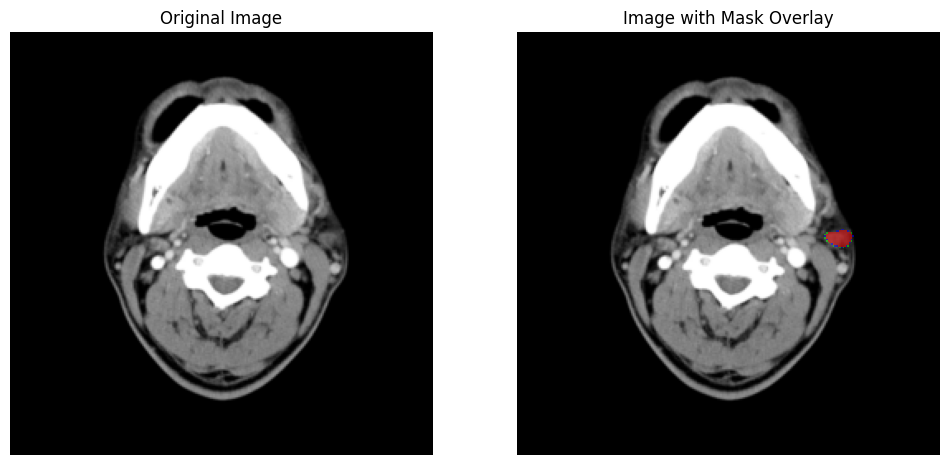

In [118]:
def visualize(image, mask):
    # Assuming the mask is a single channel tensor where 0 is background and 1, 2, 3 are classes
    # Set up class-specific colors
    colors = {
        1: [0, 1, 0, 0.5],  # Red with transparency 0.5 for Cancer
        2: [0, 0, 1, 0.5],  # Green with transparency 0.5 for Mix
        3: [1, 0, 0, 0.5],  # Blue with transparency 0.5 for Warthin
    }
    
    # Convert image to numpy if it's a tensor
    if isinstance(image, torch.Tensor):
        image = image.permute(1, 2, 0).numpy()
    
    # Create an RGBA mask with colors corresponding to classes
    mask_rgba = np.zeros((mask.shape[0], mask.shape[1], 4))
    for k, v in colors.items():
        mask_rgba[mask == k] = v
    
    # Overlay mask on image
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(image, cmap='gray')
    plt.imshow(mask_rgba, interpolation='nearest')
    plt.title('Image with Mask Overlay')
    plt.axis('off')
    plt.show()


for images, masks, classes in data_loader:
    image, mask, class_name = images[0], masks[0], classes[0]
    print(class_name)
    visualize(image, mask)
    break


In [119]:
def evaluate_model(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_pixels = 0
    
    with torch.no_grad():
        for images, masks, _ in data_loader:
            images = images.to(device)
            masks = masks.to(device)
            outputs = model(images)['out']
            loss = criterion(outputs, masks)
            preds = torch.argmax(outputs, dim=1)
            total_loss += loss.item()
            total_correct += (preds == masks).sum().item()
            total_pixels += masks.numel()
    
    avg_loss = total_loss / len(data_loader)
    accuracy = total_correct / total_pixels
    return {'loss': avg_loss, 'accuracy': accuracy}


In [47]:
# Define the model
def get_model(num_classes):
    # Load an FCN model pre-trained on COCO
    model = fcn_resnet50(pretrained=True)

    # Replace the classifier with a new one for the number of classes
    model.classifier[4] = nn.Conv2d(512, num_classes, kernel_size=(1, 1), stride=(1, 1))
    model.aux_classifier[4] = nn.Conv2d(256, num_classes, kernel_size=(1, 1), stride=(1, 1))

    return model

num_epochs = 25

# Define your transformations with augmentation
from torchvision import transforms as T

def get_transform(train):
    transform_list = []  # Renamed the list to avoid conflict
    transform_list.append(T.Resize((256, 256)))
    if train:
        transform_list.append(T.RandomHorizontalFlip(0.5))
        transform_list.append(T.RandomVerticalFlip(0.5))
        transform_list.append(T.RandomRotation(20))
        transform_list.append(T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2))
    transform_list.append(T.ToTensor())
    return T.Compose(transform_list)

# Custom Dataset with augmentation
class CustomDatasetWithAugmentation(CustomDataset):
    def __init__(self, root_dir, transform=None, augmentation=None):
        super().__init__(root_dir, transform)
        self.augmentation = augmentation

    def __getitem__(self, idx):
        img_path, json_path, class_name = self.samples[idx]
        image = Image.open(img_path).convert('RGB')
        original_size = image.size

        with open(json_path, 'r') as file:
            annotation = json.load(file)

        mask = self.create_mask_from_json(annotation, original_size, class_name)

        if self.transform:
            image = self.transform(image)
            mask = torch.from_numpy(mask).long()

        if self.augmentation:
            image, mask = self.augmentation(image, mask)

        return image, mask, class_name

# Instantiate the dataset with the transform
dataset = CustomDatasetWithAugmentation('data_20240105', transform=get_transform(train=True))

# Split dataset into train and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders for train and validation sets
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)

# Model, loss, optimizer
model = get_model(num_classes=4)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

# Learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.1)

# Move the model to the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Train and validate function
def train_and_validate(model, train_loader, val_loader, optimizer, criterion, scheduler, num_epochs, device):
    best_loss = float('inf')
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for images, masks, _ in train_loader:
            images, masks = images.to(device), masks.to(device)
            optimizer.zero_grad()
            outputs = model(images)['out']
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        val_loss = 0.0
        model.eval()
        with torch.no_grad():
            for images, masks, _ in val_loader:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)['out']
                loss = criterion(outputs, masks)
                val_loss += loss.item()
        
        scheduler.step(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
        
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(val_loader):.4f}')
    
    model.load_state_dict(best_model_wts)
    return model


# Define the number of splits for cross-validation
n_splits = 4
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Convert the CustomDatasetWithAugmentation into a list to enable indexing
dataset_list = list(dataset)

# Store the metrics for each fold
fold_metrics = []

for fold, (train_idx, val_idx) in enumerate(kf.split(dataset_list)):
    print(f"Starting fold {fold + 1}/{n_splits}")
    
    # Subset the dataset based on the indices for this fold
    train_subset = torch.utils.data.Subset(dataset, train_idx)
    val_subset = torch.utils.data.Subset(dataset, val_idx)
    
    # Create DataLoaders for training and validation subsets
    train_loader = DataLoader(train_subset, batch_size=4, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_subset, batch_size=1, shuffle=False, collate_fn=collate_fn)
    
    # Initialize the model and optimizer for this fold
    model = get_model(num_classes=4).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    criterion = nn.CrossEntropyLoss()
    
    # Train the model using the train_and_validate function you've defined
    trained_model = train_and_validate(model, train_loader, val_loader, optimizer, criterion, scheduler, num_epochs, device)
    
    # Evaluate the model and store the metrics
    fold_eval_metrics = evaluate_model(trained_model, val_loader, criterion, device)
    
    # Print the metrics for the current fold
    print(f"Fold {fold + 1}/{n_splits} - Loss: {fold_eval_metrics['loss']:.4f}, Accuracy: {fold_eval_metrics['accuracy']:.4f}")

    fold_metrics.append(fold_eval_metrics)
    
    # Optionally, save the model for this fold
    torch.save(trained_model.state_dict(), f'segmentation_model_fold_{fold}.pth')

# Calculate and print the average metrics across all folds
average_metrics = {metric: np.mean([fm[metric] for fm in fold_metrics]) for metric in fold_metrics[0]}
print("Average metrics across all folds:", average_metrics)

Starting fold 1/4
Epoch 1/25, Train Loss: 0.4031, Val Loss: 0.1710
Epoch 2/25, Train Loss: 0.1091, Val Loss: 0.0757
Epoch 3/25, Train Loss: 0.0633, Val Loss: 0.0581
Epoch 4/25, Train Loss: 0.0472, Val Loss: 0.0430
Epoch 5/25, Train Loss: 0.0397, Val Loss: 0.0431
Epoch 6/25, Train Loss: 0.0359, Val Loss: 0.0358
Epoch 7/25, Train Loss: 0.0313, Val Loss: 0.0326
Epoch 8/25, Train Loss: 0.0282, Val Loss: 0.0304
Epoch 9/25, Train Loss: 0.0263, Val Loss: 0.0284
Epoch 10/25, Train Loss: 0.0248, Val Loss: 0.0276
Epoch 11/25, Train Loss: 0.0229, Val Loss: 0.0256
Epoch 12/25, Train Loss: 0.0212, Val Loss: 0.0261
Epoch 13/25, Train Loss: 0.0210, Val Loss: 0.0242
Epoch 14/25, Train Loss: 0.0198, Val Loss: 0.0226
Epoch 15/25, Train Loss: 0.0189, Val Loss: 0.0225
Epoch 16/25, Train Loss: 0.0168, Val Loss: 0.0222
Epoch 17/25, Train Loss: 0.0173, Val Loss: 0.0214
Epoch 18/25, Train Loss: 0.0160, Val Loss: 0.0229
Epoch 19/25, Train Loss: 0.0151, Val Loss: 0.0206
Epoch 20/25, Train Loss: 0.0151, Val Loss

/mnt/data/home/willidragon/ImageProcessingHomeWork2/IMAGE_PROCESS/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/mnt/data/home/willidragon/ImageProcessingHomeWork2/IMAGE_PROCESS/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FCN_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=FCN_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


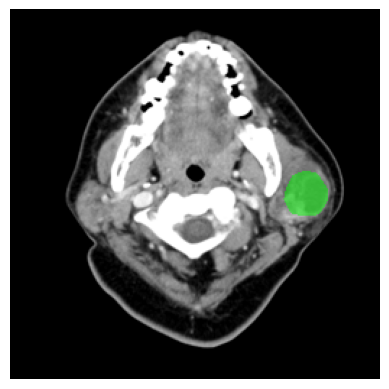

In [124]:
# Define your transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# Assuming CustomDataset is defined properly and dataset is instantiated
# Define the number of splits for cross-validation and the number of classes
n_splits = 4
num_classes = 4  # Including background as a class

# Initialize the KFold cross-validator
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Load models for each fold
models = []
for fold in range(n_splits):
    model = get_model(num_classes).to(device)
    model.load_state_dict(torch.load(f'segmentation_model_fold_{fold}.pth'))
    model.eval()
    models.append(model)

# Function to apply ensemble of models to an image and average their outputs
def ensemble_predict(models, image_tensor):
    ensemble_output = None
    for model in models:
        with torch.no_grad():
            output = model(image_tensor)['out']
        if ensemble_output is None:
            ensemble_output = output
        else:
            ensemble_output += output
    ensemble_output /= len(models)
    return ensemble_output

# Function to visualize the prediction
def visualize_prediction(image_path, prediction, alpha=0.5):
    # Read the original image
    image = Image.open(image_path).convert("RGB")
    image = image.resize((256, 256))
    image_np = np.array(image)
    
    # Create an RGBA mask where each class is colored differently with the specified transparency
    mask = prediction.cpu().numpy()
    mask_rgba = np.zeros((256, 256, 4), dtype=np.uint8)
    mask_rgba[mask == 1] = [255, 0, 0, int(255 * alpha)]  # Cancer in red
    mask_rgba[mask == 2] = [0, 255, 0, int(255 * alpha)]  # Mix in green
    mask_rgba[mask == 3] = [0, 0, 255, int(255 * alpha)]  # Warthin in blue

    # Overlay the mask on the image
    overlayed_image = image.copy()
    overlayed_image.paste(Image.fromarray(mask_rgba, mode='RGBA'), (0, 0), Image.fromarray(mask_rgba, mode='RGBA'))
    
    # Display the image with the overlay
    plt.imshow(overlayed_image)
    plt.axis('off')
    plt.show()

# Prediction and visualization for a new image
image_path = 'demo_test9/b59-15762303_9.png'  # Replace with your image path
image = Image.open(image_path).convert("RGB")
image_tensor = transform(image).unsqueeze(0).to(device)

# Predict using the ensemble
ensemble_output = ensemble_predict(models, image_tensor)
prediction = torch.argmax(ensemble_output, dim=1).squeeze(0)

# Visualize the prediction
visualize_prediction(image_path, prediction, alpha=0.5)



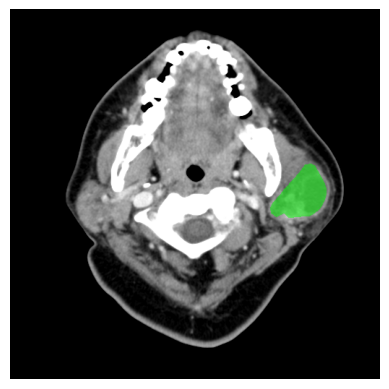

In [125]:
import json
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2

# Load the image
image_path = 'demo_test9/b59-15762303_9.png'
original_image = Image.open(image_path)
original_image_array = np.array(original_image)

# Load the JSON data
json_path = 'demo_test9/b59-15762303_9.json'
with open(json_path, 'r') as file:
    annotations = json.load(file)

# Create an empty mask with the same size as the original image
mask = np.zeros(original_image_array.shape[:2], dtype=np.uint8)

# Define colors for different classes (in RGB format)
colors = {
    'cancer': [255, 0, 0],   # Red
    'mix': [0, 255, 0],      # Green
    'warthin': [0, 0, 255]   # Blue
}

# Define unique values for each class
class_values = {
    'cancer': 1,
    'mix': 2,
    'warthin': 3
}

# Draw the polygons on the mask
for shape in annotations['shapes']:
    label = shape['label'].lower()
    if label in class_values:
        polygon = np.array(shape['points'], dtype=np.int32)
        cv2.fillPoly(mask, [polygon], class_values[label])  # Using unique values for each class

# Create an RGBA mask with colors corresponding to the classes
mask_rgb = np.zeros((*original_image_array.shape, 4), dtype=np.uint8)
for label, value in class_values.items():
    mask_rgb[mask == value] = [*colors[label], 128]  # Applying the correct color based on class value

# Convert mask to PIL image for alpha compositing
mask_pil = Image.fromarray(mask_rgb, 'RGBA')

# Overlay the mask on the original image
original_image_pil = original_image.convert('RGBA')
overlayed_image = Image.alpha_composite(original_image_pil, mask_pil)

# Display the image with the overlay
plt.imshow(overlayed_image)
plt.axis('off')
plt.show()


In [128]:
import numpy as np
import torch

def dice_coefficient(pred_mask, gt_mask):
    pred_flat = pred_mask.flatten()
    gt_flat = gt_mask.flatten()
    intersection = np.sum(pred_flat * gt_flat)
    print(intersection)
    union = np.sum(pred_flat) + np.sum(gt_flat)
    dice = (2. * intersection + 1e-6) / (union + 1e-6)
    return dice

def resize_prediction(prediction, target_shape):
    if len(prediction.shape) == 2:  # 如果只有两个维度，增加一个通道维度
        prediction = prediction.unsqueeze(0)
    prediction = prediction.unsqueeze(0)  # 增加一个批次维度
    resized_prediction = torch.nn.functional.interpolate(prediction.float(), 
                                                         size=target_shape, 
                                                         mode='nearest').squeeze(0)
    return resized_prediction.squeeze(0)

# 检查预测和掩码的尺寸是否相符
if prediction.shape[1:] != mask.shape:
    resized_prediction = resize_prediction(prediction, mask.shape)
else:
    resized_prediction = prediction

# 转换预测结果为整数类型
resized_prediction_int = resized_prediction.cpu().numpy().astype(np.int64)

# 确定预测结果中最常见的类别
predicted_class_value = np.argmax(np.bincount(resized_prediction_int.flatten(), minlength=num_classes))

# 如果最常见的类别是背景（0），则选择第二常见的类别
if predicted_class_value == 0:
    predicted_class_value = np.argmax(np.bincount(resized_prediction_int.flatten(), minlength=num_classes)[1:]) + 1

# 计算该类别的Dice Coefficient
pred_class_mask = (resized_prediction_int == predicted_class_value)
gt_class_mask = (mask == predicted_class_value)
dice_score = dice_coefficient(pred_class_mask, gt_class_mask)

# 将类别数值映射回类别名称
class_labels = {1: 'cancer', 2: 'mix', 3: 'warthin'}
predicted_class_label = class_labels.get(predicted_class_value, 'unknown')

print(f'Dice Coefficient for {predicted_class_label}: {dice_score}')


2793
Dice Coefficient for mix: 0.8354771163871557
